In [1]:
from pathlib import Path
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from pycoingecko import CoinGeckoAPI

# Loading & Preprocessing

## Import BTC Skew Data

In [2]:
btc_skew = pd.read_csv(f"../data/btc_25_skew.csv")
btc_skew['DateTime'] = pd.to_datetime(btc_skew['DateTime'])
btc_skew = btc_skew.set_index('DateTime')

In [3]:
btc_skew.describe()

,Skew 7 Days
count,1095.000000
mean,4.892237
std,9.801193
min,-40.280000
25%,-1.440000
50%,5.400000
75%,11.240000
max,39.540000


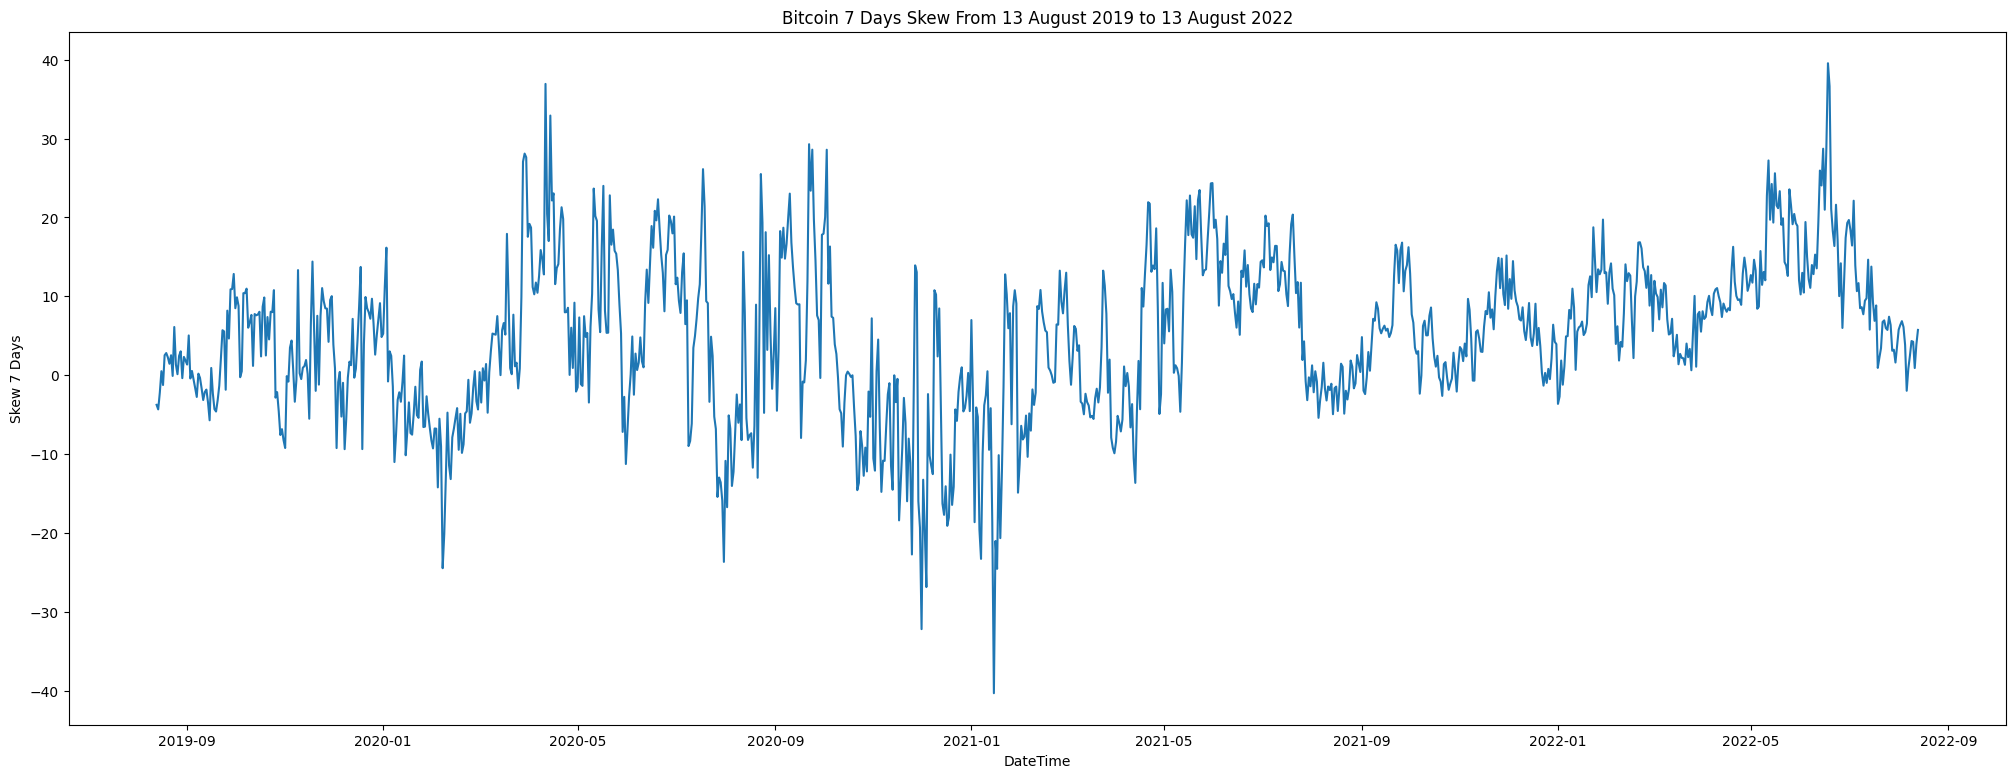

In [4]:
plt.figure(figsize=(25,9))

plt.title("Bitcoin 7 Days Skew From 13 August 2019 to 13 August 2022")

sns.lineplot(data=btc_skew, x=btc_skew.index, y='Skew 7 Days')

plt.show()

From the graph, the data looks like it is stationary as it is centered around 0. However, let us make sure that it is truly stationary by running an Augmented Dicker-Fuller Test (https://machinelearningmastery.com/time-series-data-stationary-python/).

I need my data to be stationary to be able to apply a statistical or machine learning model to predict a target. This applies for both the features and the label.

In [5]:
X = btc_skew.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.278410
p-value: 0.000484
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Running the AD-Fuller test yields us a P value of <1% meaning that the data has a less than 1% chance of being not stationary. Which means it is good to use.

## Get Bitcoin Price (2019-08-06 - 2022-09-13)

In [6]:
cg = CoinGeckoAPI()
data = cg.get_coin_market_chart_range_by_id(id="bitcoin", vs_currency='usd', from_timestamp="1562976000" , to_timestamp="1663027200")

In [7]:
df = pd.DataFrame(np.array(data['prices']), columns=['datetime', 'price_usd'])
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms', origin='unix')
df = df.set_index('datetime')
df

,price_usd
datetime,
2019-07-13,11804.562794
2019-07-14,11418.511855
2019-07-15,10285.461109
2019-07-16,10911.345158
2019-07-17,9538.827124
...,...
2022-09-09,19322.777749
2022-09-10,21359.582526
2022-09-11,21707.387319


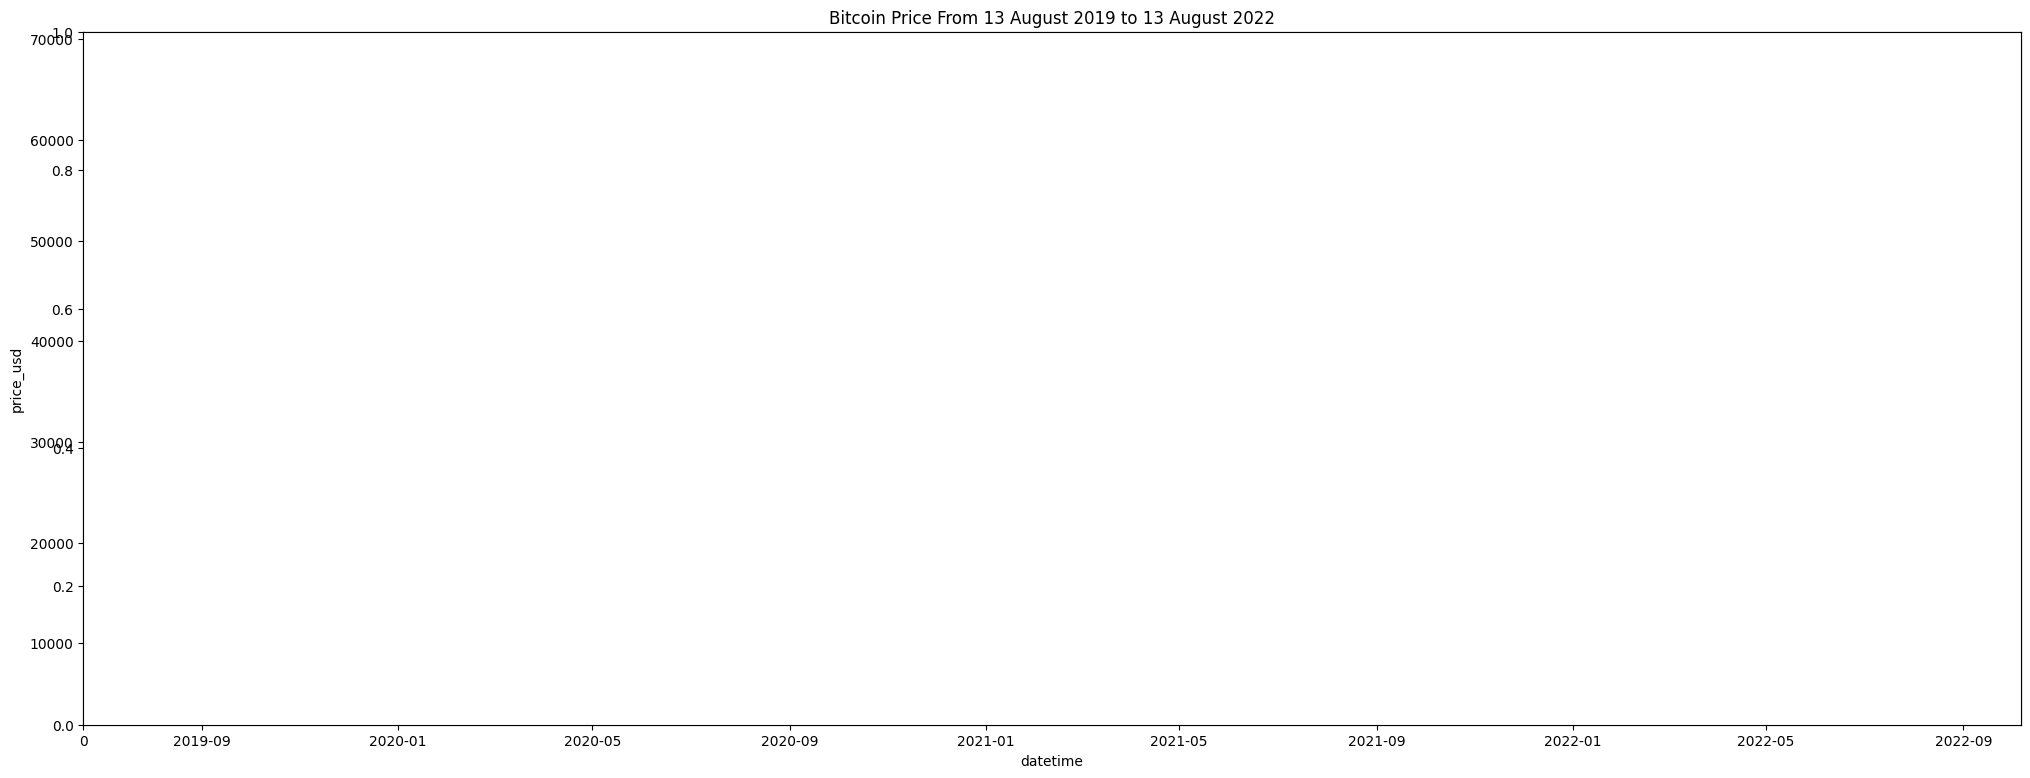

In [8]:
_temp = df.loc['2019-08-13':'2022-08-13']
_temp = _temp.reset_index()
_temp

plt.figure(figsize=(25,9))

plt.title("Bitcoin Price From 13 August 2019 to 13 August 2022")

sns.lineplot(data=_temp, x='datetime', y='price_usd')

plt.axes().xaxis.set_major_locator(locator=MultipleLocator(90))

plt.show()

Looking at the graph it is safe to say that the price of bitcoin is not stationary as over time the average price over a period of time increases of decreases.

In [9]:
X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.303729
p-value: 0.627465
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Now we know for sure that the price is not stationary. However, There are ways to make a non-stationary data to be stationary such as finding the percent change between 2 data points. As it happens it is also the data we're trying to predict.

## Apply Stationarity to Price Column

In [10]:
df['price_diff_1_day_pct'] = df['price_usd'].pct_change(periods=1) * 100
df['price_diff_7_day_pct'] = df['price_usd'].pct_change(periods=7) * 100
df['price_diff_30_day_pct'] = df['price_usd'].pct_change(periods=30) * 100
df

,price_usd,price_diff_1_day_pct,price_diff_7_day_pct,price_diff_30_day_pct
datetime,,,,
2019-07-13,11804.562794,NaN,NaN,NaN
2019-07-14,11418.511855,-3.270354,NaN,NaN
2019-07-15,10285.461109,-9.922928,NaN,NaN
2019-07-16,10911.345158,6.085134,NaN,NaN
2019-07-17,9538.827124,-12.578816,NaN,NaN
...,...,...,...,...
2022-09-09,19322.777749,0.218625,-4.124239,-16.725376
2022-09-10,21359.582526,10.540952,7.111474,-10.811581
2022-09-11,21707.387319,1.628331,9.552686,-9.359003


In [11]:
_temp = df.loc['2019-08-13':'2022-08-13']
_temp = _temp.reset_index()
_temp

,datetime,price_usd,price_diff_1_day_pct,price_diff_7_day_pct,price_diff_30_day_pct
0,2019-08-13,11381.241356,-1.461100,-3.699989,-0.326404
1,2019-08-14,10903.654992,-4.196259,-5.269335,6.010366
2,2019-08-15,10016.217389,-8.138900,-16.326924,-8.203643
3,2019-08-16,10295.877143,2.792070,-14.374640,7.936511
4,2019-08-17,10324.993597,0.282797,-12.888083,6.913840
...,...,...,...,...,...
1092,2022-08-09,23823.679442,2.698882,2.099663,10.347799
1093,2022-08-10,23203.680697,-2.602447,0.649930,11.236278
1094,2022-08-11,23948.829553,3.211339,4.761105,19.753322
1095,2022-08-12,23948.751704,-0.000325,5.601763,23.761443


In [12]:
for i in ['price_diff_1_day_pct', 'price_diff_7_day_pct', 'price_diff_30_day_pct']:
    print(i)
    X = _temp.loc[:, i]
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print()

price_diff_1_day_pct
ADF Statistic: -15.496235
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

price_diff_7_day_pct
ADF Statistic: -5.251211
p-value: 0.000007
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

price_diff_30_day_pct
ADF Statistic: -4.233616
p-value: 0.000578
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568



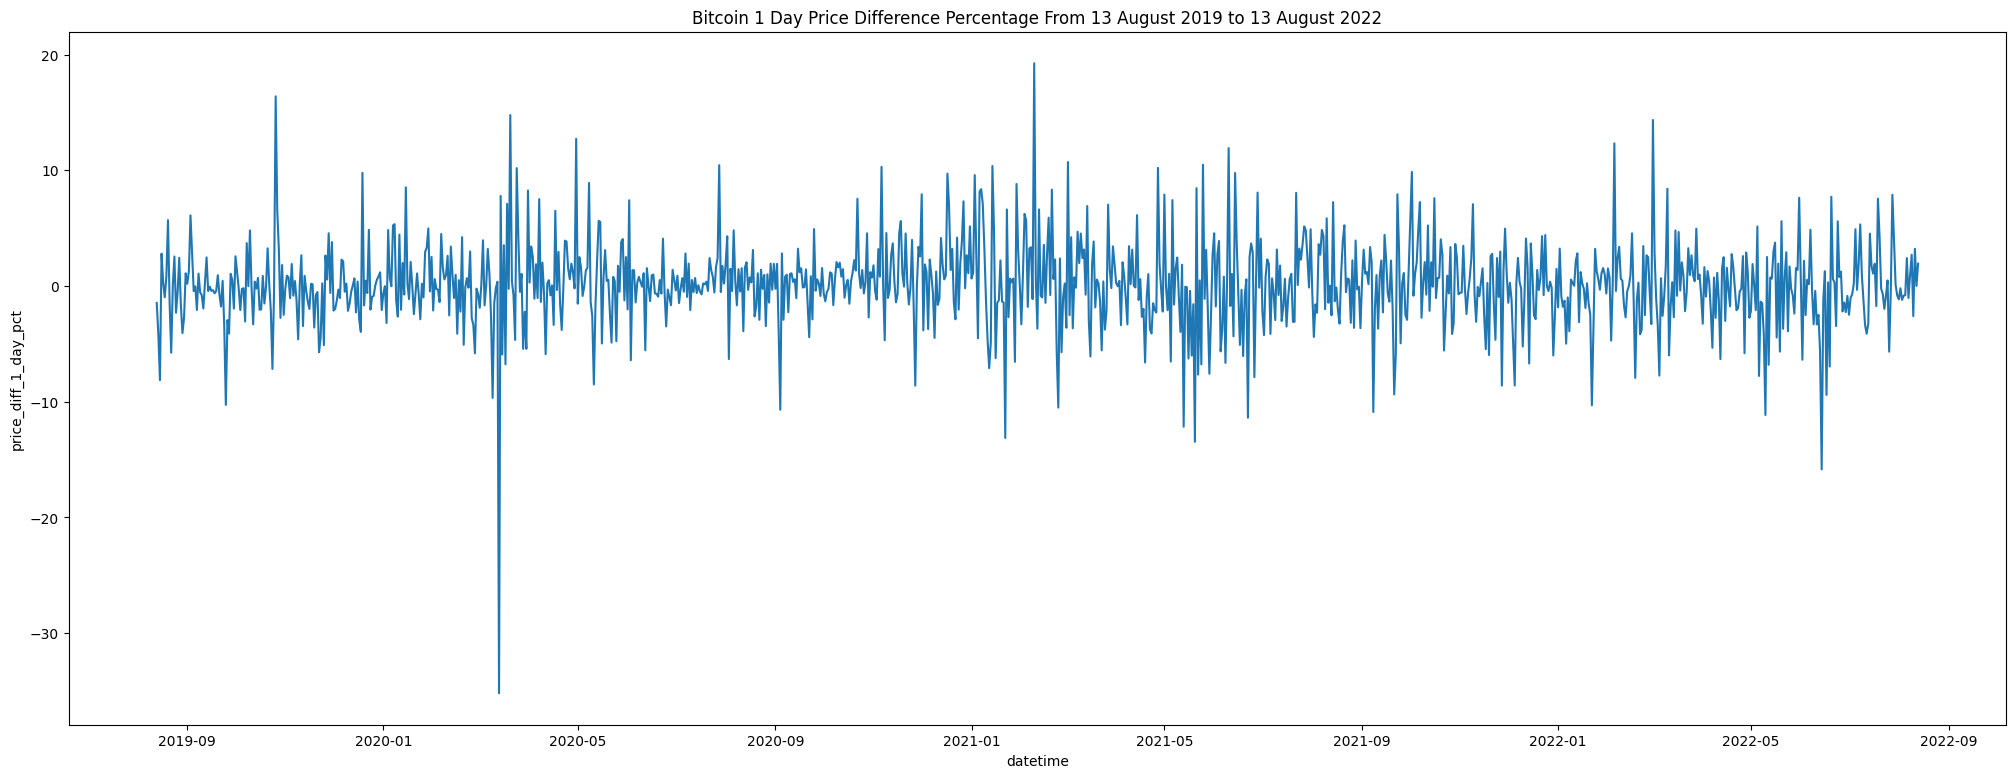

In [13]:
plt.figure(figsize=(25,9))

plt.title("Bitcoin 1 Day Price Difference Percentage From 13 August 2019 to 13 August 2022")

sns.lineplot(data=_temp, x='datetime', y='price_diff_1_day_pct')

plt.show()

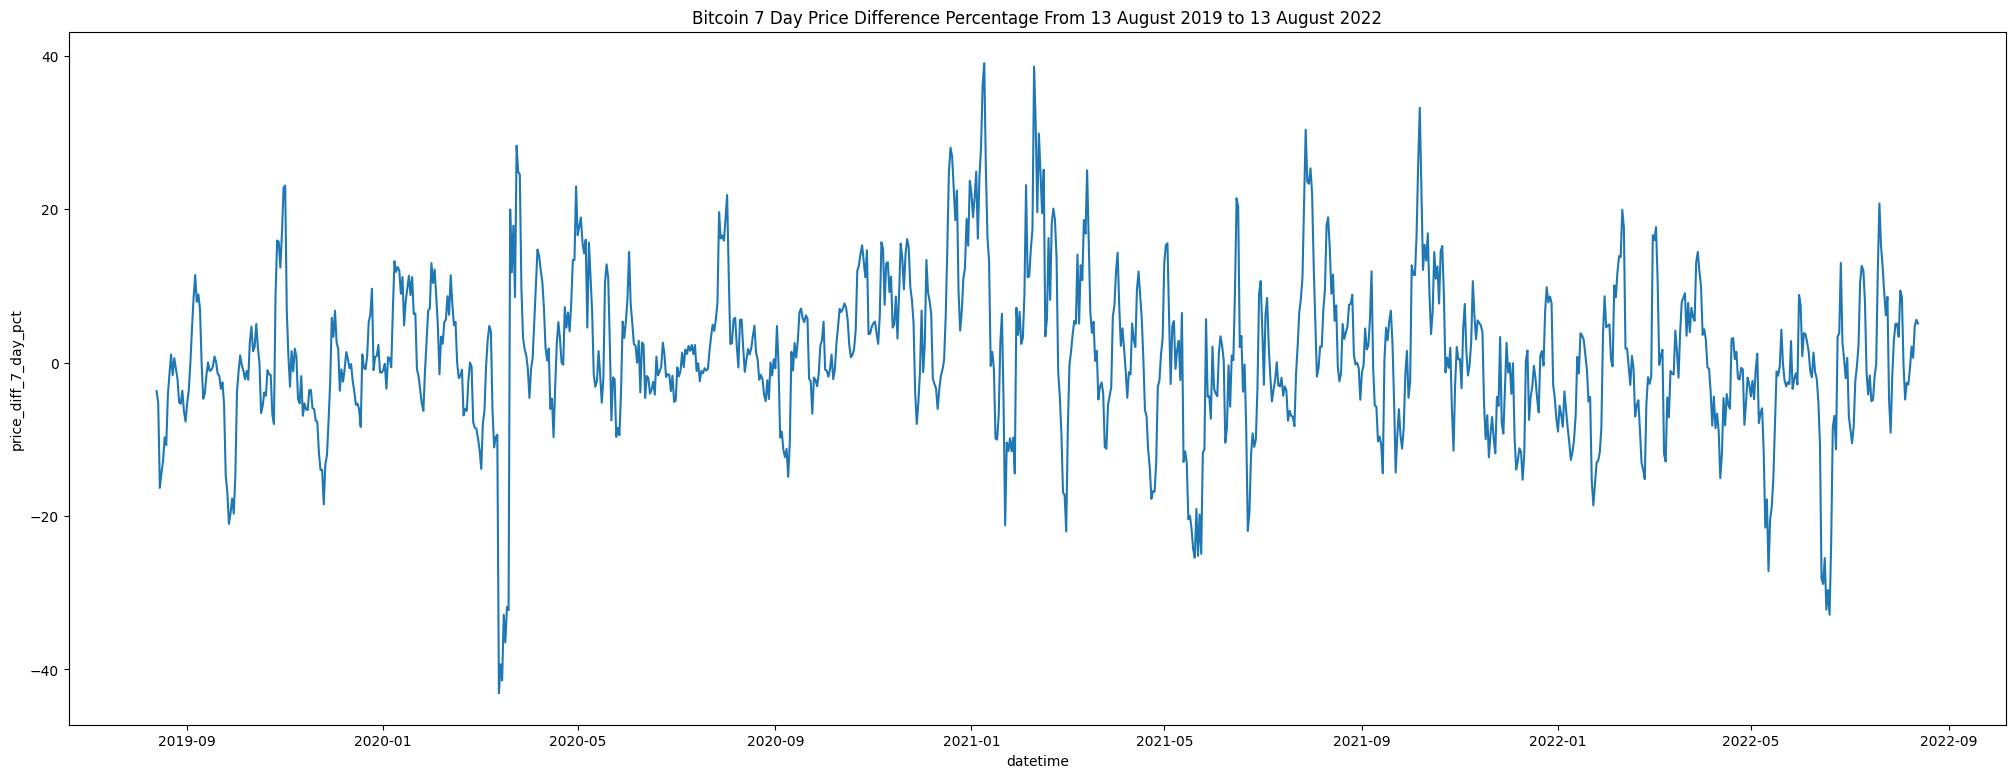

In [14]:
plt.figure(figsize=(25,9))

plt.title("Bitcoin 7 Day Price Difference Percentage From 13 August 2019 to 13 August 2022")

sns.lineplot(data=_temp, x='datetime', y='price_diff_7_day_pct')

plt.show()

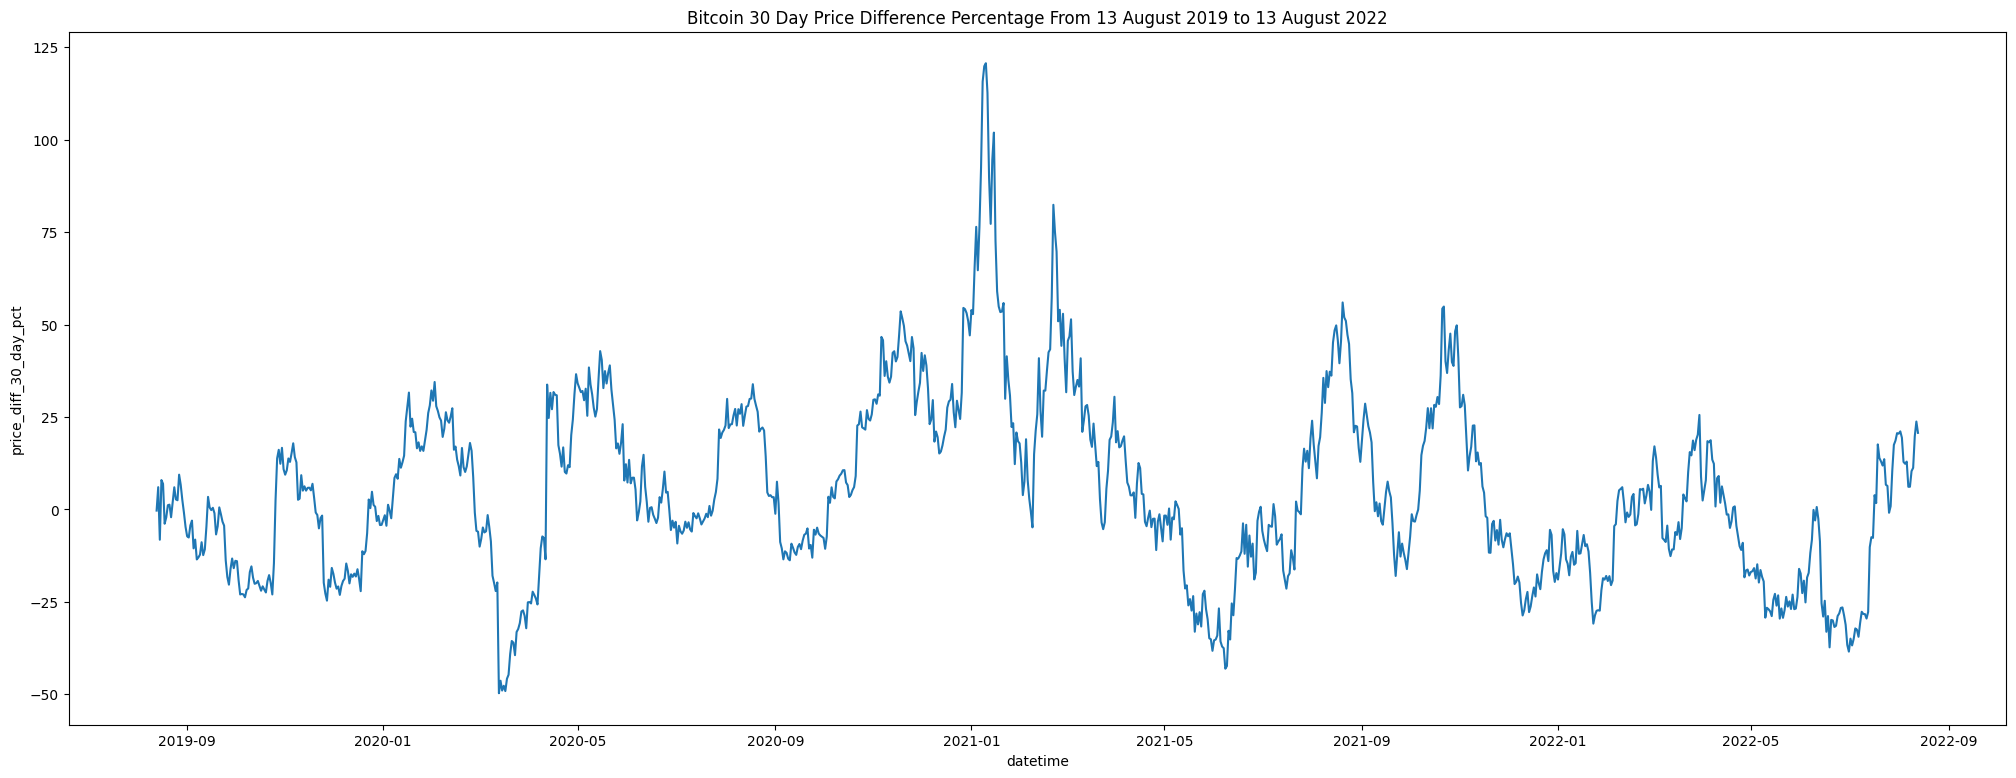

In [15]:
plt.figure(figsize=(25,9))

plt.title("Bitcoin 30 Day Price Difference Percentage From 13 August 2019 to 13 August 2022")

sns.lineplot(data=_temp, x='datetime', y='price_diff_30_day_pct')

plt.show()

Ussually what we can do to predict 30 days into the future is predict day by day and on each iteration we incorporate our prediction to predict the next day. In real life condition during training this would expose us to our model's weakness as bad model would compound their bad prediction and over a long period of time the 30 days prediction would be very different with reality. However, for the purpose of this experiment, I would like to directly predict the future 30 days percent change value instead using bitcoin last 7 days skew value. 

In [16]:
# Create label - Bitcoin Price Change (%) in the next 30 days
df['future_30days_price_change'] = df['price_diff_30_day_pct'].shift(-30)

# Combine btc_skew with btc_price
df2 = df.merge(btc_skew, left_index=True, right_index=True)

# Drop 1 day and 7 day price difference column
df2 = df2.drop(columns=['price_diff_1_day_pct', 'price_diff_7_day_pct', 'price_usd', 'price_diff_30_day_pct'])
df2

,future_30days_price_change,Skew 7 Days
2019-08-13,-10.811925,-3.74
2019-08-14,-4.607034,-4.32
2019-08-15,3.388600,-2.20
2019-08-16,0.521323,0.52
2019-08-17,-0.187105,-1.23
...,...,...
2022-08-09,-19.069489,4.34
2022-08-10,-16.725376,4.25
2022-08-11,-10.811581,0.92
2022-08-12,-9.359003,3.88


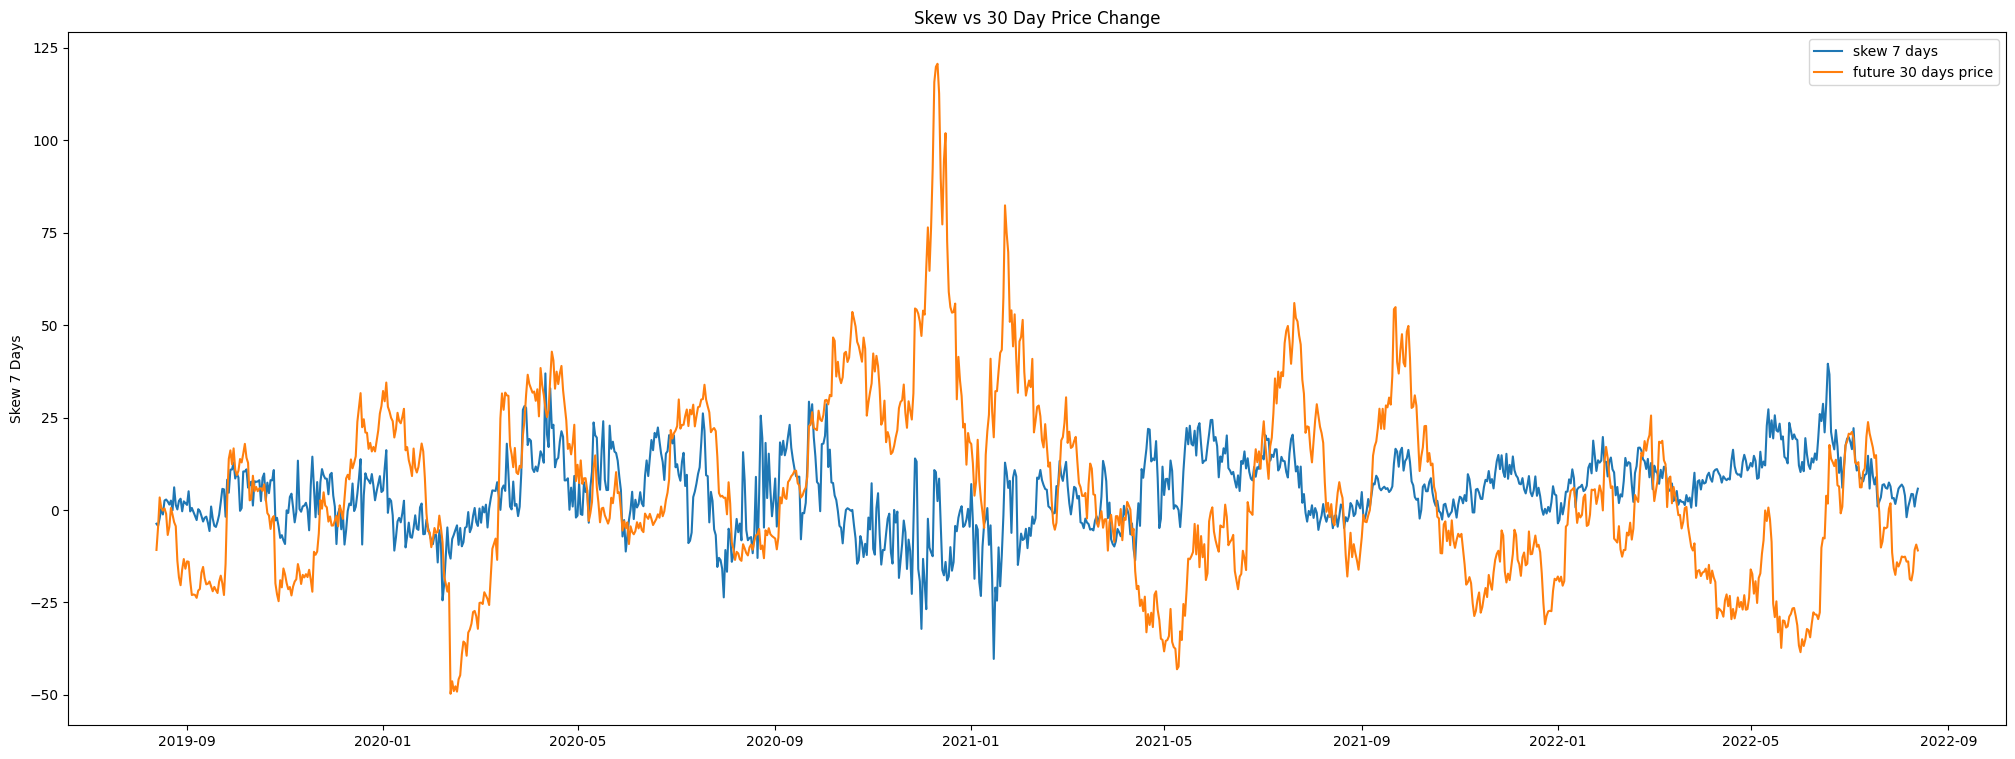

In [17]:
plt.figure(figsize=(25,9))

plt.title("Skew vs 30 Day Price Change")

sns.lineplot(data=df2, x=df2.index, y='Skew 7 Days', label='skew 7 days')
sns.lineplot(data=df2, x=df2.index, y='future_30days_price_change', label='future 30 days price')

plt.legend()
plt.show()

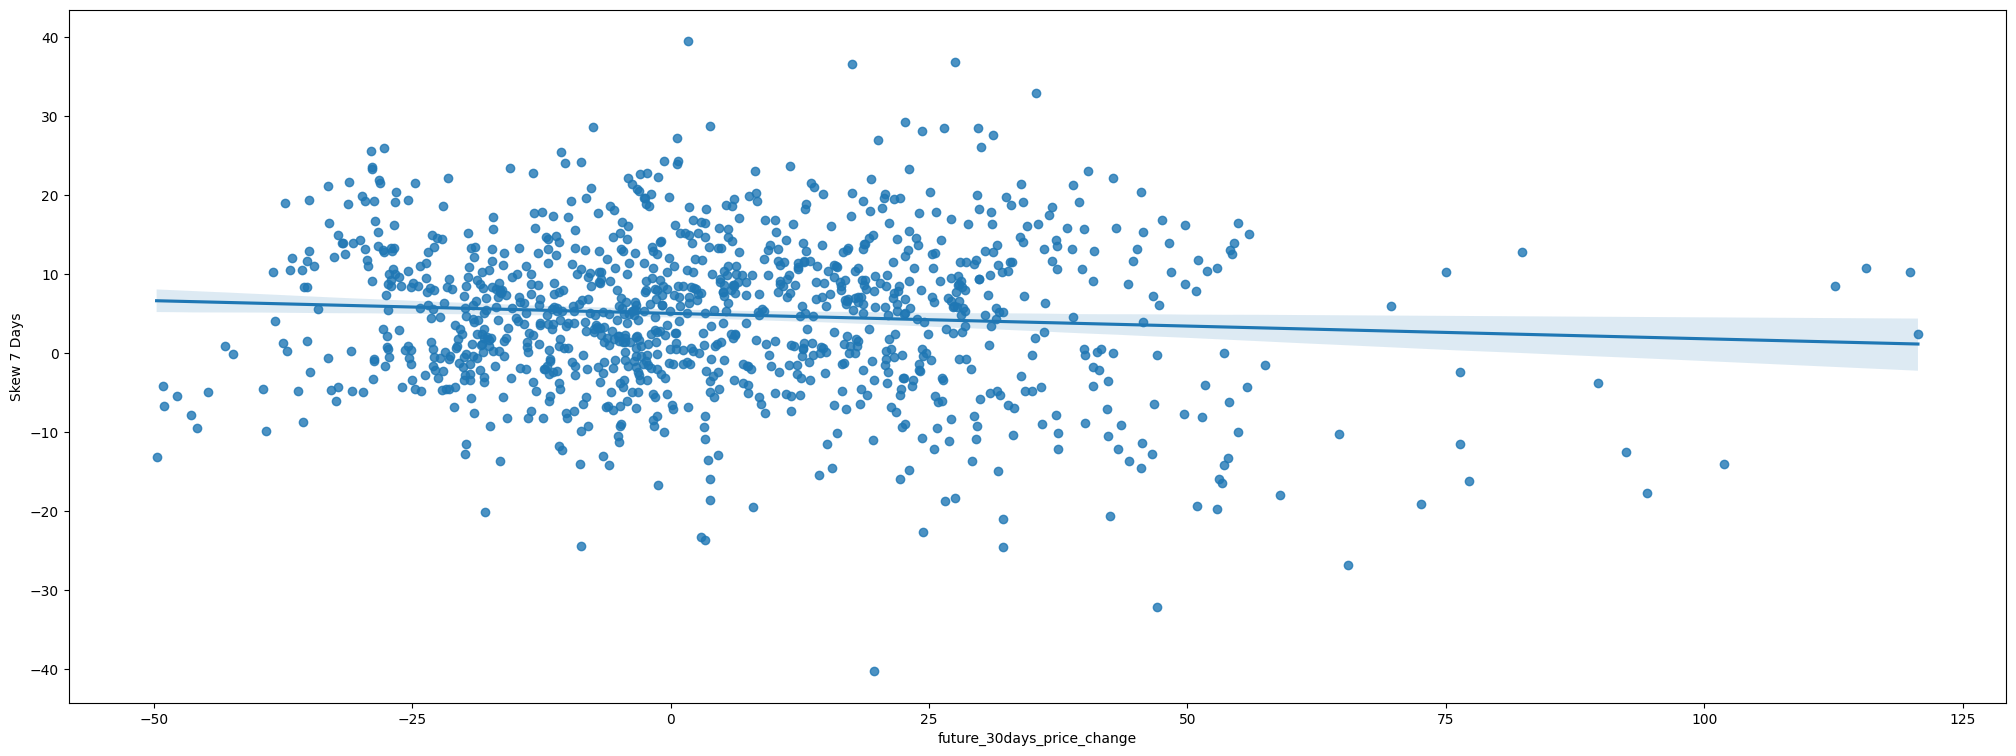

In [18]:
fig = plt.figure(figsize = (25, 9))
sns.regplot(data = df2, x = 'future_30days_price_change', y ='Skew 7 Days')
plt.show()

There is no obvious correlation between the Skew and Next 30 Days Price Change value by looking at the scatter plot

In [19]:
# Check correlation between these 2 

df2['future_30days_price_change'].corr(df2['Skew 7 Days'])

-0.07930691334000106

Checking the pearson correlation value also shows a very weak negative cross correlation between these two variables

# Conclusion

it can be concluded that these two variables are not heavily correlated and thus have little predictive power on BTCUSD 30 day future % change in price. 7% negative correlation can be useful if it is combined with other features when building a machine learning model to predict the 30 day future % change in price. However, on its own it is too weak and thus not useful.